In [501]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss,accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [40]:
np.random.seed(27)
FILE_PATH="task1_data.tsv"

In [8]:
def open_data(filename=FILE_PATH):
    return pd.read_csv(filename,delimiter="\t")

In [10]:
data=open_data()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54099 entries, 0 to 54098
Columns: 204 entries, search_flags_0 to ind
dtypes: float64(105), int64(99)
memory usage: 84.2 MB


In [585]:
data.describe()

,search_flags_0,search_flags_1,search_flags_2,search_flags_3,search_flags_4,search_flags_5,search_flags_6,search_flags_7,search_flags_8,session_ip_cc_0,...,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99,click
count,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,...,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000,54099.000000
mean,0.754007,0.244496,0.000536,0.000499,0.000148,0.000055,0.000092,0.000055,0.000111,0.994214,...,0.922512,0.939442,0.935256,0.915578,0.940102,0.931167,0.957804,0.946347,0.924926,0.427531
std,0.430679,0.429792,0.023147,0.022335,0.012160,0.007447,0.009613,0.007447,0.010531,0.075844,...,0.052394,0.038632,0.040001,0.059016,0.040507,0.045640,0.035031,0.078497,0.125651,0.494725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.629200,0.400900,0.457500,0.516300,0.381400,0.375100,0.553800,0.379300,0.109700,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.902200,0.927200,0.915700,0.887500,0.924000,0.916900,0.952400,0.932800,0.937100,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.933800,0.946900,0.943000,0.932700,0.949700,0.939700,0.966500,0.966000,0.965300,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.958200,0.963800,0.964600,0.957500,0.966650,0.959400,0.975900,0.990900,0.981900,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [584]:
len(data.columns)

203

In [171]:
train_data,test_data = train_test_split(data,test_size=0.2,random_state=42)

In [172]:
print("{} train samples + {} test  samples".format(len(train_data),len(test_data)))

43279 train samples + 10820 test  samples


In [343]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["click"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [174]:
corr_matrix=data.corr()

In [587]:
corr_matrix["click"].sort_values(ascending=False)

click                          1.000000
cluster_78                     0.116759
cluster_90                     0.107241
cluster_95                     0.105410
cluster_71                     0.098058
cluster_9                      0.096305
cluster_94                     0.095300
cluster_67                     0.090245
cluster_73                     0.090097
cluster_84                     0.088551
cluster_93                     0.087191
2gram_boost_42                 0.086341
2gram_boost_1                  0.086341
2gram_boost_11                 0.086341
query_title_2gram_0            0.086341
cluster_17                     0.081103
cluster_41                     0.075225
cluster_92                     0.070650
cluster_72                     0.070392
cluster_23                     0.066880
title_view_1                   0.064695
2gram_boost_0                  0.063108
2gram_boost_7                  0.063108
2gram_boost_31                 0.063108
cluster_33                     0.061911


In [437]:
trainX = strat_train_set.drop("click",axis=1)
trainY= strat_train_set["click"]
testX = strat_test_set.drop("click",axis=1)
testY = strat_test_set["click"]

In [457]:
num_features = [column for column in trainX.columns  if len(trainX[column].value_counts())>2]
cat_features = list(set(trainX.columns)-set(num_features))

In [293]:
data[cat_features].hist(bins=10,figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x158866828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15d5213c8>]], dtype=object)

In [540]:
np.var(data["2gram_boost_15"])

0.059834103337800794

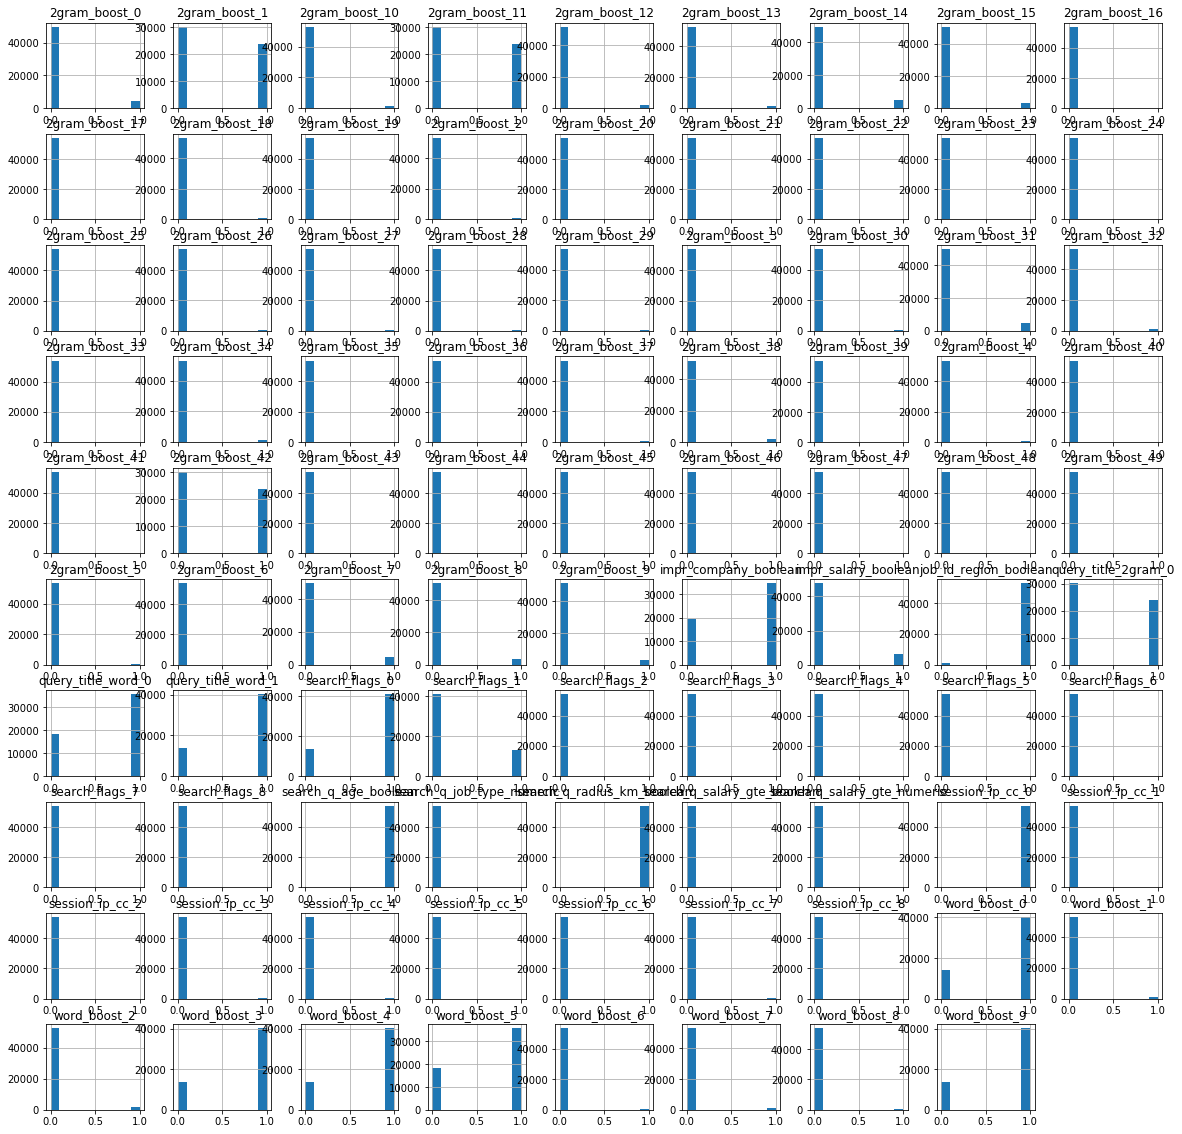

In [514]:
plt.show()

In [601]:
data[num_features].hist(bins=20,figsize=(30,30))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1d3443cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x18a0be7f0>]], dtype=object)

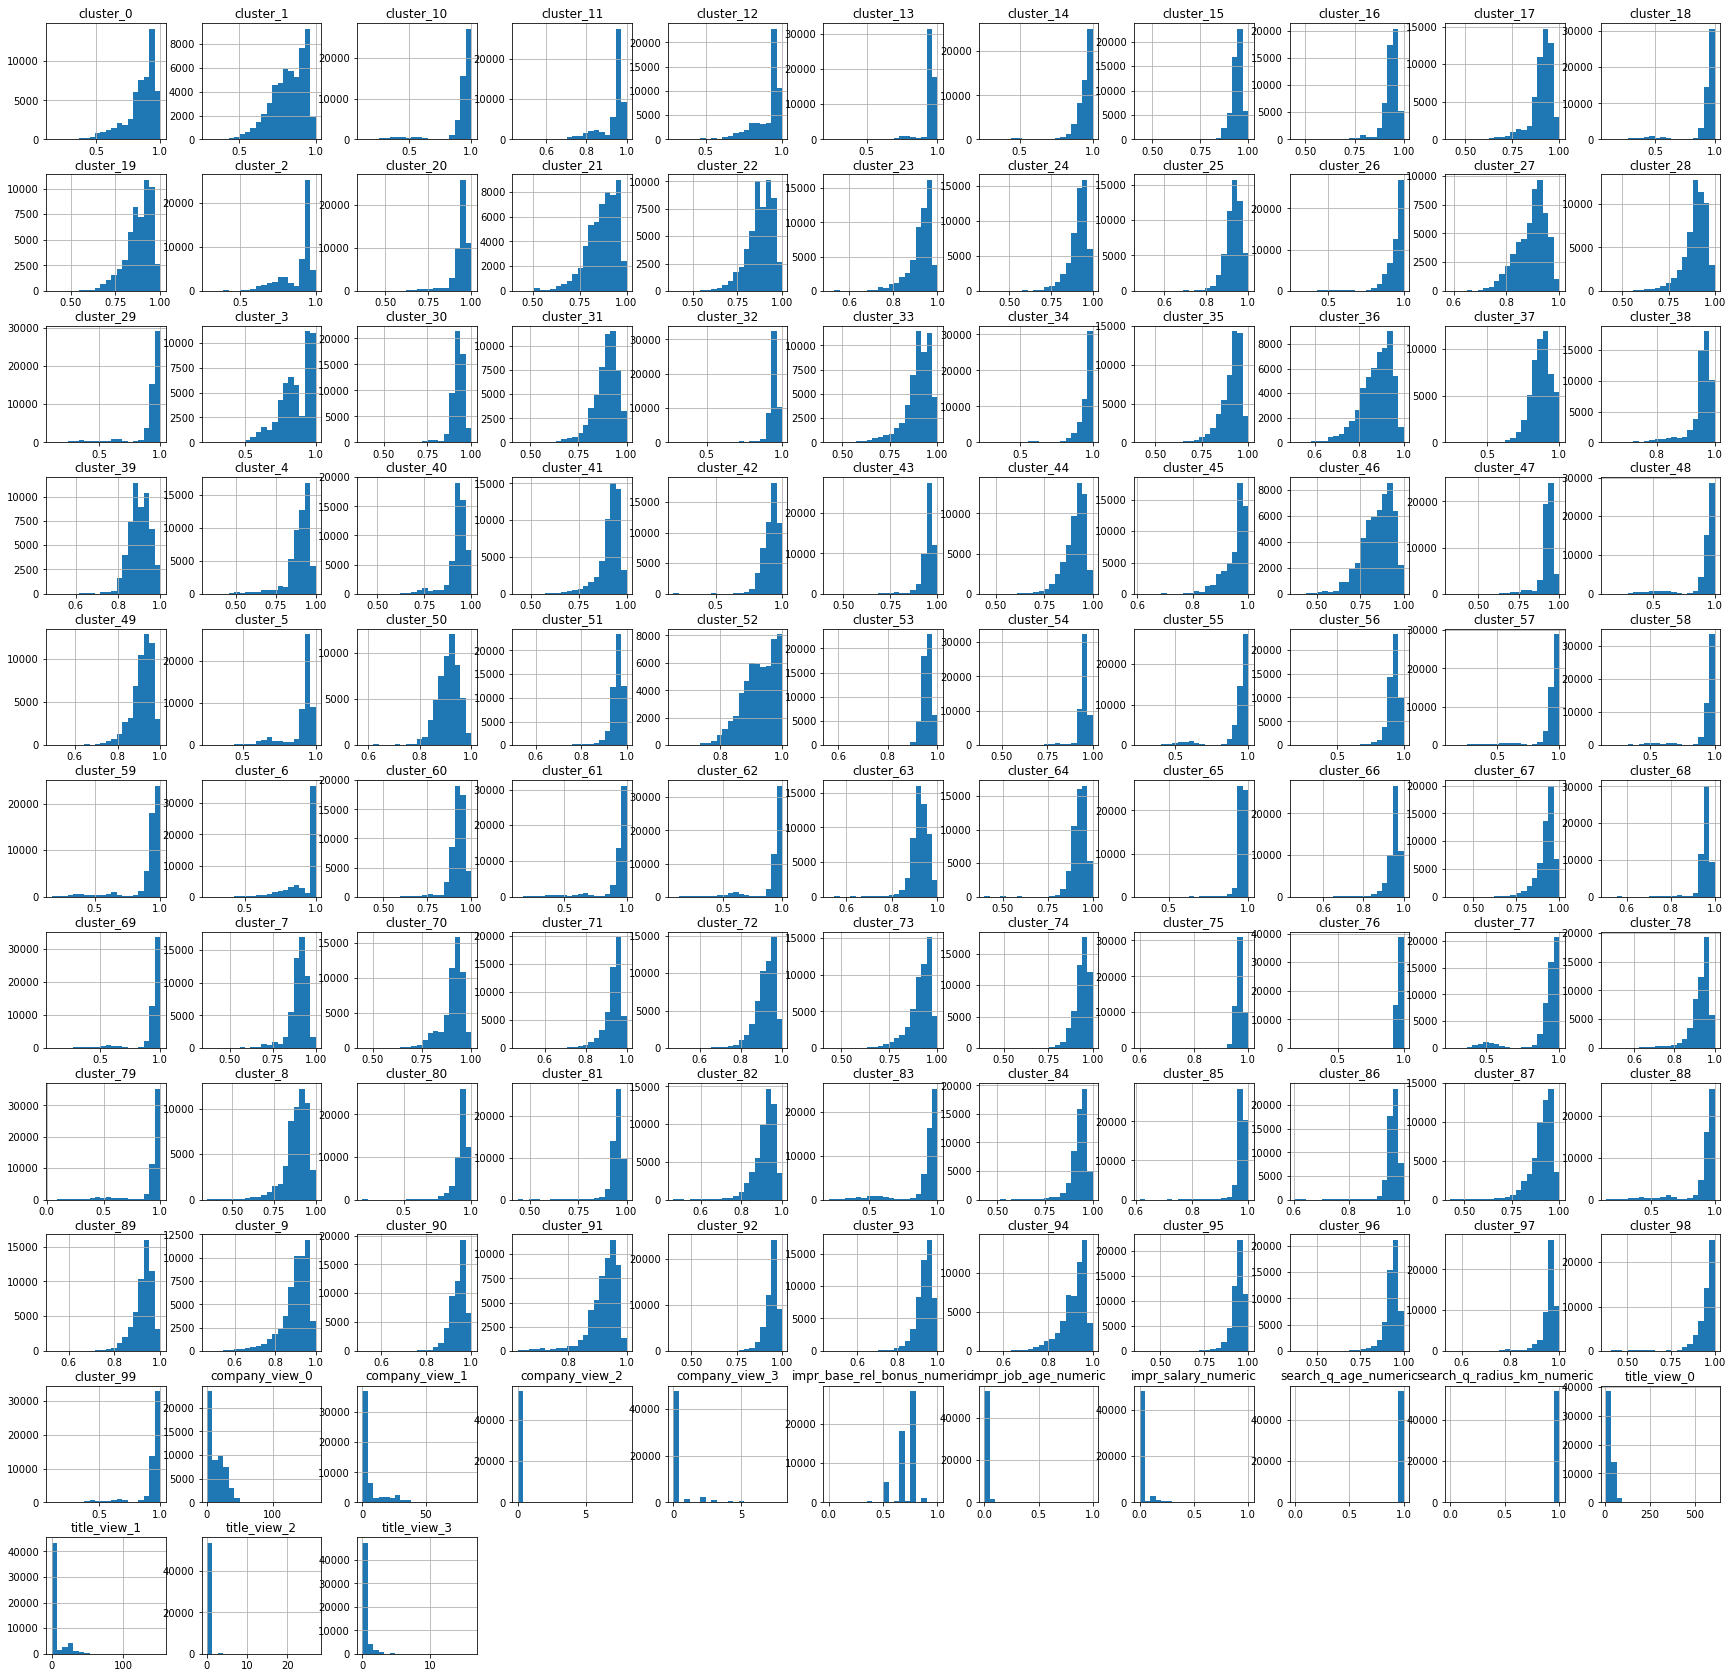

In [602]:
plt.show()

In [589]:
#Variance disctionary
var_dict=dict(data.var(axis=0))

In [600]:
list(var_dict.values())

[0.0006072328894319777,
 0.019762258586003476,
 0.0022868827004476674,
 0.0097554201622753606,
 0.0031163433066206322,
 0.0014057435703355827,
 0.0079350242717109772,
 0.0048379133540150084,
 5.5451839963209177e-05,
 0.021039518882099744,
 0.082569151672950022,
 9.2416316393640011e-05,
 0.0033215262059063228,
 0.0030927155306427713,
 0.0016001035142917581,
 0.0019699082114955188,
 222.78556385468798,
 0.0076641568699728803,
 0.019135266985885597,
 0.19121079849053688,
 0.0046353798328399413,
 0.0008126772478893277,
 0.01614057706865631,
 0.0034907440837548659,
 0.00083113180938700797,
 0.00011089752954487696,
 0.0012369592682868835,
 0.026574376528746599,
 0.022871227738274408,
 0.0021942717680001052,
 0.0020874611395725827,
 0.0054392148952776874,
 0.0002809718113150004,
 0.011791452494628468,
 0.039132022594188701,
 0.0019813931815957672,
 5.5451839963209557e-05,
 0.0016177560862282532,
 0.0061617119853531526,
 0.0014581802917664078,
 0.0065164911104404607,
 0.003539270458353679,
 0.

In [574]:
'''pca=PCA(n_components=0.95)
train_arr = pca.fit_transform(trX)
test_arr = pca.fit_transform(tsX)
'''

In [631]:
class VarianceFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variance_rate=0.1):
        self.variance_rate = variance_rate
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        indecies=[i for i in range(X.shape[1]) if(np.var(X[:,i])>self.variance_rate)]  
        print(len(indecies))
        return X[:,indecies]
       

In [632]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
       

In [633]:
num_pipeline = Pipeline([
    ("num_selector",DataFrameSelector(num_features)),
    ('std_scaler', StandardScaler()),
    ("var_selector",VarianceFeatureSelector()),
    ('imputer', Imputer(strategy="median")),                        
])

In [634]:
cat_pipeline = Pipeline([
    ("cat_selector",DataFrameSelector(cat_features)),
    ("var_selector",VarianceFeatureSelector())
])

In [635]:
full_pipiline = FeatureUnion([
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline)
])

In [636]:
trX=full_pipiline.fit_transform(trainX)

113
15


In [637]:
tsX=full_pipiline.fit_transform(testX)

113
15


In [625]:
model = LogisticRegression()

In [626]:
model.fit(trX,trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [630]:
print(model.score(tsX,testY))

0.615804066543


In [616]:
predY=model.predict(tsX)

In [617]:
print(log_loss(predY,testY))

13.2698614752


In [618]:
model.predict_proba(tsX)

array([[ 0.68526721,  0.31473279],
       [ 0.46573479,  0.53426521],
       [ 0.70881734,  0.29118266],
       ..., 
       [ 0.60428116,  0.39571884],
       [ 0.34811595,  0.65188405],
       [ 0.82116586,  0.17883414]])